In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from scipy.stats import gaussian_kde
from torchvision.transforms import Compose
from src.datasets.tools.transforms import LoadNP, CloudIntensityNormalize, CloudAngleNormalize
from src.datasets.tools.transforms import Corruption, GlobalShift
from src.datasets.dublin.config import config as dublin_config

# for dark-mode
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

# more readable font size?
matplotlib.rcParams.update({'font.size': 18})

In [2]:
dataset_path = Path("../synth_crptn+shift/150")

# confirm that our files exist, and that the number of examples is in line with
#   our expectations. This also shows the number of source-target pairs. 

dataset_path = Path("../dublin/150")
dataset_files = [f for f in dataset_path.glob("neighborhoods/*.txt.gz")]
example_counts = {}
for example in dataset_files:
    src, target, intensity, _ = str(example.stem).split("_")
    if (src, target) not in example_counts:
        example_counts[(src, target)] = 1
    else:
        example_counts[(src, target)] += 1

totals = []
idx = 0
# some pretty formatting
for key, val in example_counts.items():
    print(f"{key}: {val}", end='  ')
    totals.append(val)
    if idx % 4 == 3:
        print()
    idx+=1
print()

print(f"Mean: {np.mean(totals)}\tStd: {np.std(totals)}")

('8', '8'): 51274  ('2', '2'): 51194  ('32', '32'): 51484  ('35', '35'): 51123  
('30', '30'): 51182  ('32', '1'): 50834  ('12', '1'): 51001  ('16', '16'): 51063  
('39', '1'): 51006  ('35', '1'): 51018  ('21', '1'): 51022  ('40', '1'): 50981  
('10', '1'): 50819  ('8', '1'): 50498  ('22', '22'): 51055  ('26', '26'): 51153  
('10', '10'): 51237  ('0', '0'): 51412  ('11', '1'): 50479  ('6', '6'): 51386  
('27', '27'): 51310  ('21', '21'): 51038  ('37', '37'): 51378  ('30', '1'): 51047  
('27', '1'): 50870  ('19', '1'): 50565  ('40', '40'): 51158  ('20', '1'): 51036  
('19', '19'): 51240  ('7', '1'): 51049  ('34', '34'): 51439  ('34', '1'): 50785  
('11', '11'): 51029  ('37', '1'): 48461  ('15', '1'): 51013  ('16', '1'): 50733  
('9', '1'): 50817  ('26', '1'): 49446  ('12', '12'): 51068  ('4', '1'): 50889  
('22', '1'): 50930  ('6', '1'): 51027  ('4', '4'): 51308  ('39', '39'): 51347  
('7', '7'): 51187  ('20', '20'): 51215  ('15', '15'): 51285  ('0', '1'): 50861  
('2', '1'): 42569  ('9

In [3]:
dataset_csv = {'train': dataset_path / "train.csv",
              'val': dataset_path / "val.csv",
              'test': dataset_path / "test.csv"}

df = {key: pd.read_csv(value) for key, value in dataset_csv.items()}
[f"{key}: {(len(value))}" for key, value in df.items()]

['train: 2032436', 'val: 254054', 'test: 254054']

In [4]:
x = 20
y = 20
matplotlib.rcParams['figure.figsize'] = [x*1.5, y*1.5]

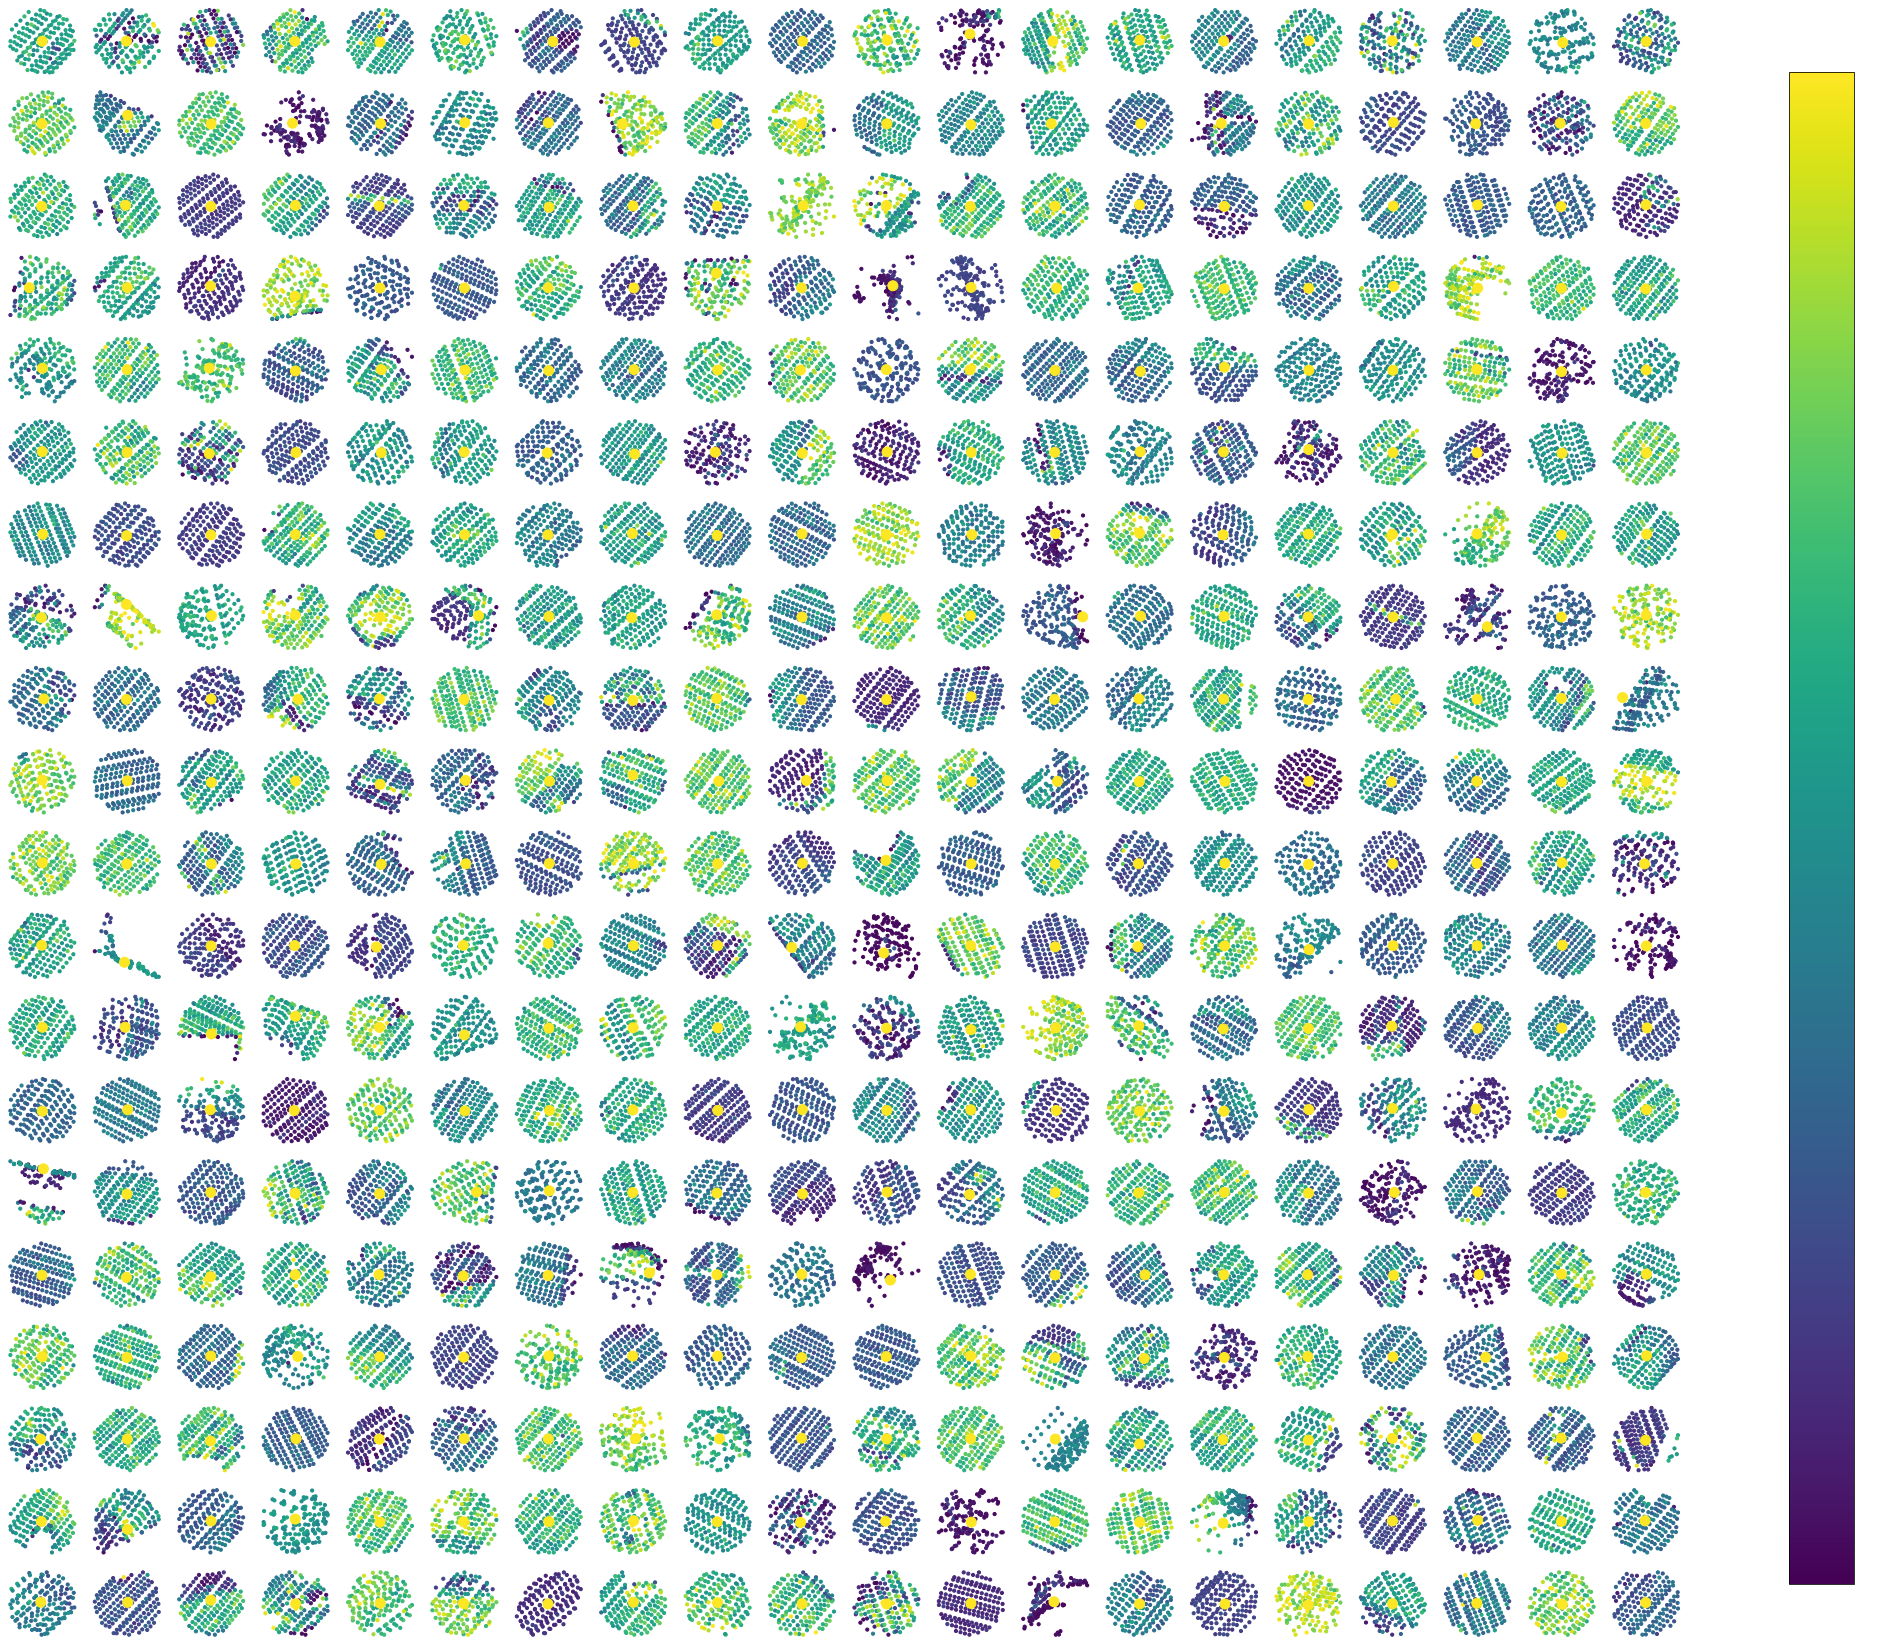

In [5]:
# Visualize Intenties
sample = np.random.choice(len(df['train']), (x, y))
fig, ax = plt.subplots(y, x)
for i in range(y):
    for j in range(x):
        example = np.loadtxt(df['train'].iloc[sample[j, i]][1])
        example = np.flip(example, axis=0)  # reverse so center pt is on top
        # Adjust the gt-center to be more visible
        center = np.ones((example.shape[0])) * 10
        center[-1] = 100
        intensity = example[:, 3]
        intensity[-1] = 512
        s = ax[i][j].scatter(example[:, 0], example[:, 1], s=center, c=example[:, 3], vmin=0, vmax=512)
        ax[i][j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(s, cax=cbar_ax)

plt.show()

[308616]


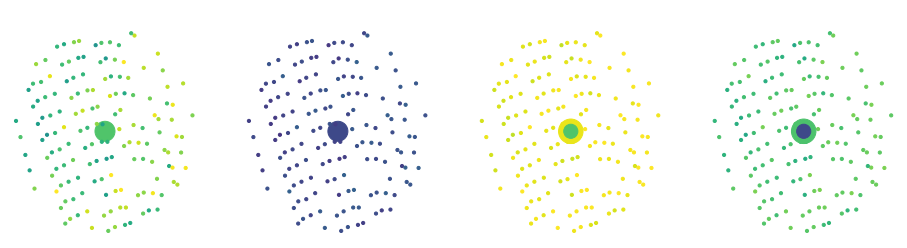

In [6]:
# Test transformations - this is a litle messy. The figure below shows the 
#   stages of transformation. Notably, the two neighborhoods to the right show 
#   the effect of the `Corruption` transformation, which duplicates the gt 
#   center point, and produces a corrupted copy of the ground truth. This 
#   serves as the interpolation target. This is illustrated by the enlarged 
#   center point, with a concentric cirle within. The inner circle is the 
#   harmonization target. Note that the enlarged point on the two leftmost 
#   neighborhoods is just an interpolation target, since there is no applied
#   corruption for which we need to harmonize. 

matplotlib.rcParams['figure.figsize'] = [16, 4]
matplotlib.rcParams.update({'font.size': 12})
# sample = np.random.choice(len(df['train']), 1)  # search
sample = [308616]
print(sample)

# gt
t1 = Compose([LoadNP(), CloudAngleNormalize(), CloudIntensityNormalize(512)])

# shifted gt
t2 = Compose([
    LoadNP(), 
    CloudAngleNormalize(), 
    GlobalShift(**dublin_config), 
    CloudIntensityNormalize(512)])

# corrupted gt
t3 = Compose([
    LoadNP(), 
    CloudAngleNormalize(), 
    Corruption(**dublin_config), 
    CloudIntensityNormalize(512)])

# shifted+corrupted gt
t4 = Compose([
    LoadNP(), 
    CloudAngleNormalize(), 
    GlobalShift(**dublin_config),
    Corruption(**dublin_config), 
    CloudIntensityNormalize(512)])


ex = df['train'].iloc[sample]['examples'].item()
fig, ax = plt.subplots(1, 4)
ex1 = t1(ex); ex2 = t2(ex); ex3 = t3(ex); ex4 = t4(ex)
vm=1

for i in range(4):
    if i == 0:
        center = np.ones((ex1.shape[0])) * 10
        center[0] = 400  # make the target center more visible
        ax[i].scatter(ex1[:, 0], ex1[:, 1], s=center, c=ex1[:, 3], vmin=0, vmax=vm)
        ax[i].set_title("Ground Truth")
    if i == 1:
        center = np.ones((ex2.shape[0])) * 10
        center[0] = 400  # make the target center more visible
        ax[i].scatter(ex2[:, 0], ex2[:, 1], s=center, c=ex2[:, 3], vmin=0, vmax=vm)
        ax[i].set_title("Global Shift")
    if i == 2:
        ex3 = np.flip(ex3, axis=0)
        center = np.ones((ex3.shape[0])) * 10
        center[-1] = 200
        center[-2] = 600
        ax[i].scatter(ex3[:, 0], ex3[:, 1], s=center, c=ex3[:, 3], vmin=0, vmax=vm)
        ax[i].set_title("Corruption")
    if i == 3:
        ex4 = np.flip(ex4, axis=0)
        center = np.ones((ex4.shape[0])) * 10
        center[-1] = 200
        center[-2] = 600
        ax[i].scatter(ex4[:, 0], ex4[:, 1], s=center, c=ex4[:, 3], vmin=0, vmax=vm)
        ax[i].set_title("Global Shift + Corruption")
    ax[i].axis('off')

